In [1]:
!pip uninstall cello_multiplier --yes
!pip install -U git+https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git

Found existing installation: cello-multiplier 0.0.1
Uninstalling cello-multiplier-0.0.1:
  Successfully uninstalled cello-multiplier-0.0.1
  Cloning https://github.com/Bishop-Laboratory/CellO-MultiPLIER.git to c:\users\julia\appdata\local\temp\pip-req-build-x6xfoi70
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for cello-multiplier: filename=cello_multiplier-0.0.1-py3-none-any.whl size=26280814 sha256=32f3751244f23595dbd58ba745526640e57768d868b37cde389d9b123ce5f03e
  Stored in directory: C:\Users\julia\AppData\Local\Temp\pip-ephem-wheel-cache-_ws2_8uy\wheels\4e\a2\13\7caa6e484f87d31e5fbaef2a13beef986a14a300708738afa0
Successfully built cello-multiplier


In [4]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd

In [5]:
B_df, Z_df, labels, per_gene_mean, per_gene_std, train_dummies_specific, train_dummies_full, classifiers = cm.get_default_mats()

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
#CellO split 
from pathlib import Path
import json

split_dir = Path('data/CellO_data/bulk_RNA_seq_training_set/pretraining_validation_split/')



with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [54]:
# Load full CellO data

In [53]:
cello_data = pd.read_csv("plierInput.mat.csv").T
cello_data.head

<bound method NDFrame.head of               TSPAN6      TNMD      DPM1     SCYL3  C1orf112       FGR  \
SRX890545   0.071963  0.068414  3.718085  2.184815  1.490935  6.995514   
SRX1067711  0.033104  0.000000  3.743323  1.990195  1.780348  6.565519   
SRX1067710  0.233484  0.000000  3.376271  1.523096  0.611052  5.667817   
SRX762971   0.000000  0.000000  0.270898  0.272666  0.046180  4.310495   
SRX762970   0.000000  0.000000  0.000000  0.153331  0.029985  3.570165   
...              ...       ...       ...       ...       ...       ...   
SRX3399308  0.900313  0.000000  4.034299  2.548069  1.914284  6.135145   
SRX3399309  0.317015  0.000000  3.972622  2.634532  2.009371  6.394950   
SRX3399310  0.799190  0.000000  4.109202  2.661645  2.445280  6.295505   
SRX3399311  0.044163  0.000000  4.007751  2.015217  1.989733  6.363111   
SRX3399312  1.064050  0.000000  3.668019  2.255745  2.194389  5.908714   

                 CFH     FUCA2      GCLC      NFYA  ...  MIR6715B  \
SRX890545   

## Training of LR using CellO split

In [55]:
train_Y_df = cello_data[cello_data.index.isin(train_egs)]
train_Y_df.shape

(3609, 55904)

In [56]:
test_Y_df = cello_data[cello_data.index.isin(validation_egs)]
test_Y_df.shape

(684, 55904)

In [57]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }

types_per_b_samples = B_df.index.map(sample2types).values

mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

samples_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

celltypes = samples_dummies.columns.tolist()

type2samples = {
    type_: samples_dummies.index[samples_dummies[type_] == 1].tolist()
    for type_ in celltypes
}
types_sizes = samples_dummies.sum() # no of times a celltype occours in the dataset

In [58]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target(celltype, type2samples, train_Y_df, test_Y_df,):
    samplelist = type2samples[celltype]
    samplelist_train = [x for x in samplelist if x in train_Y_df.index.values]
    samplelist_test = [x for x in samplelist if x in test_Y_df.index.values]
    
    target_train = pd.Series(0,index = train_Y_df.index)
    target_train.loc[samplelist_train] = 1
    
    target_test = pd.Series(0,index = test_Y_df.index)
    target_test.loc[samplelist_test] = 1
    
    train_Y_transformed = train_Y_df #used to contain standard scaling, removed
    test_Y_transformed = test_Y_df
    
    return(target_train.values, target_test.values, train_Y_transformed, test_Y_transformed )

In [59]:
def fscore(p, r):
    denom = p + r or 1

    return 2*(p * r) / denom

In [60]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, average_precision_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [61]:
types_with_data = types_sizes.index.values # all celltypes that occour in the data
all_types = samples_dummies.columns # get list of celltypes

In [62]:
def LR_classify(solver,penalty):

    warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []
    aps = []
    for cell_type in tqdm(all_types):
        train_target, train_test, train_data, test_data = set_target(
            cell_type, type2samples, train_Y_df, test_Y_df
        )

        if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = penalty,random_state=111 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(train_test, target_pred)
            test_precision += [precision_score(train_test, target_pred)]
            test_recall += [recall_score(train_test, target_pred)]
            aps += [average_precision_score(train_test, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
           
            
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 
    ap = np.mean(aps)

    
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}, average precision avg: {ap:.4f}')#
    
    return aps # returns the average precision of every successfully trained classifier

In [63]:
report = LR_classify("liblinear","l1")


precision: 0.6261, recall: 0.5168, f1: 0.5402, f1 micro avg: 0.5662, average precision avg: 0.4914


## Training of LR using split of 30 % test data

In [64]:
from sklearn.model_selection import train_test_split
data = cello_data

In [65]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target_full(celltype, type2samples, data):
    samplelist = type2samples[celltype]
    samplelist = [x for x in samplelist if x in data.index.values]
    
    target = pd.Series(0,index = data.index)
    target.loc[samplelist] = 1
    
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.30, random_state=111)
    return(train_data, test_data, train_target.values, test_target.values)

In [66]:
def LR_classify_sklearn_split(solver,penalty):

    warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

    successful_celltypes = []
    unsuccessful_celltypes = []
    test_prs = []
    test_precision = []
    test_recall = []
    fscores = []
    aps = []
    for cell_type in tqdm(all_types):
        train_data, test_data, train_target, test_target = set_target_full(
            cell_type, type2samples, data
        )

        if(1 in train_target and 1 in test_target and 0 in train_target and 0 in test_target):
            # lasso penalty
            clf = LogisticRegression(solver = solver,penalty = penalty,random_state=111 )

            clf.fit(train_data, train_target)
            target_pred = clf.predict(test_data)
            test_pr = metrics.average_precision_score(test_target, target_pred)
            test_precision += [precision_score(test_target, target_pred)]
            test_recall += [recall_score(test_target, target_pred)]
            aps += [average_precision_score(test_target, target_pred)]
            fscores += [fscore(test_precision[-1], test_recall[-1])]
            successful_celltypes += [cell_type]
           
            
        else:
            unsuccessful_celltypes += [cell_type]

    p = np.mean(test_precision)
    r = np.mean(test_recall)
    f = np.mean(fscores)
    f_micro = fscore(p, r) 
    ap = np.mean(aps)

    
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}, average precision avg: {ap:.4f}')#
    
    return aps # returns the average precision of every successfully trained classifier

In [67]:
report1 = LR_classify_sklearn_split("liblinear","l1")


precision: 0.8804, recall: 0.8468, f1: 0.8512, f1 micro avg: 0.8633, average precision avg: 0.8136


<AxesSubplot:>

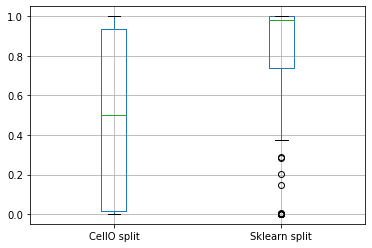

In [68]:
reportdf = pd.DataFrame(list(zip(report,report1)), columns = ["CellO split","Sklearn split"])
reportdf.boxplot()